In [1]:
from mantisshrimp.all import *

In [2]:
source = Path('../nbs/samples').absolute()
annot_json = json.load((source/'annotations.json').open())

In [6]:
parser = COCOParser(annot_json, source/'images')
records = parser.parse()


Removed 0 images that don't have annotations


In [8]:
id2cat = {o['id']:o['name'] for o in annot_json['categories']}

In [21]:
im = open_img(records[3].iinfo.fp)

In [ ]:
im.shape

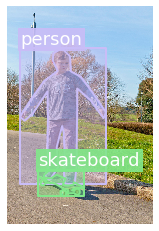

In [17]:
show_record(records[3], id2cat=id2cat, draw_bbox=True)